Skewness of Numeric Features:

loan_status                   2.046848
cb_person_cred_hist_length    1.618503
person_age                    1.498285
person_income                 1.283326
loan_amnt                     1.188578
person_emp_length             0.957892
loan_percent_income           0.917473
loan_int_rate                 0.200020
id                            0.000000
dtype: float64


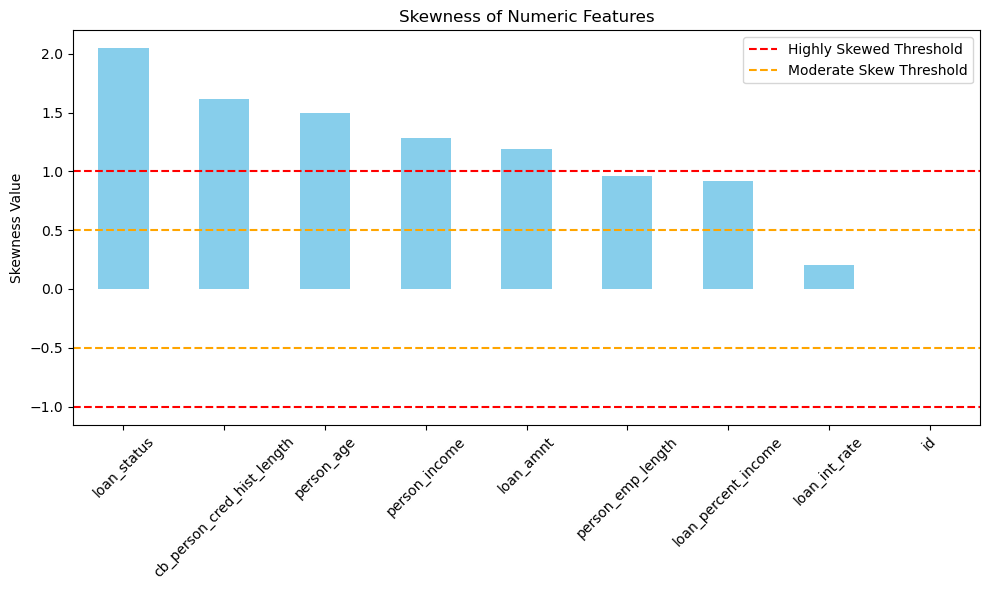

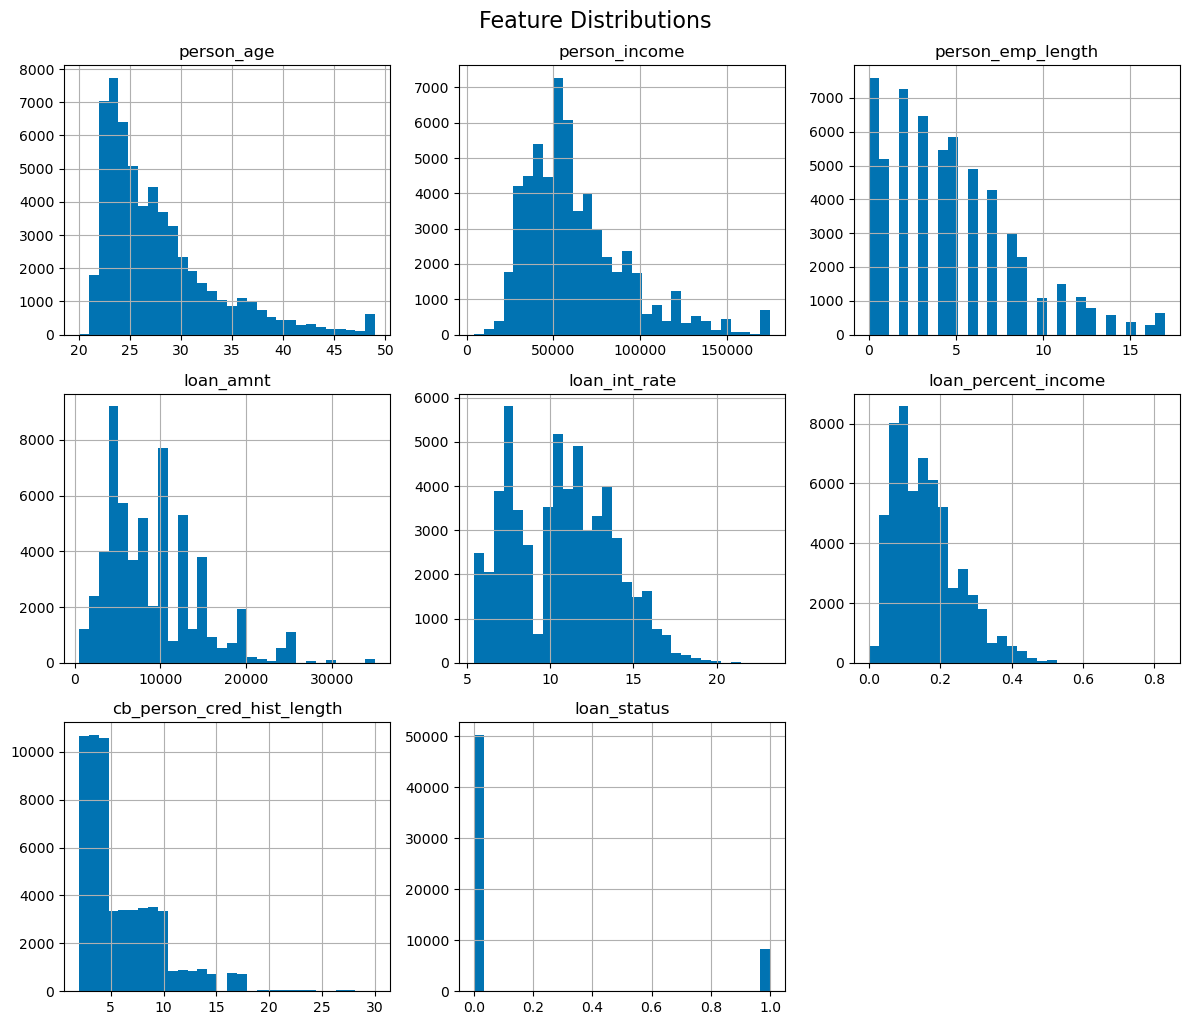

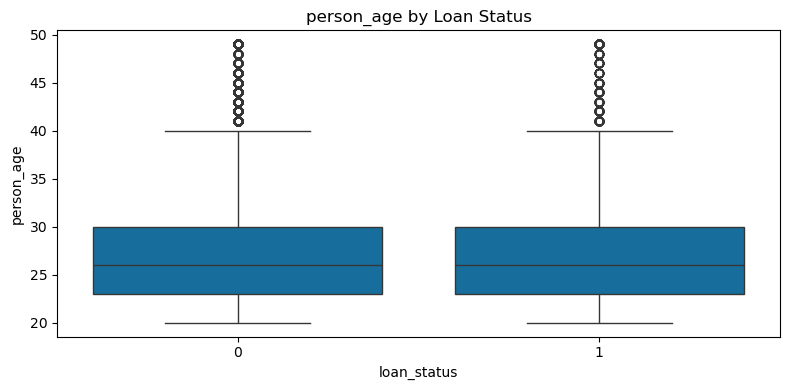

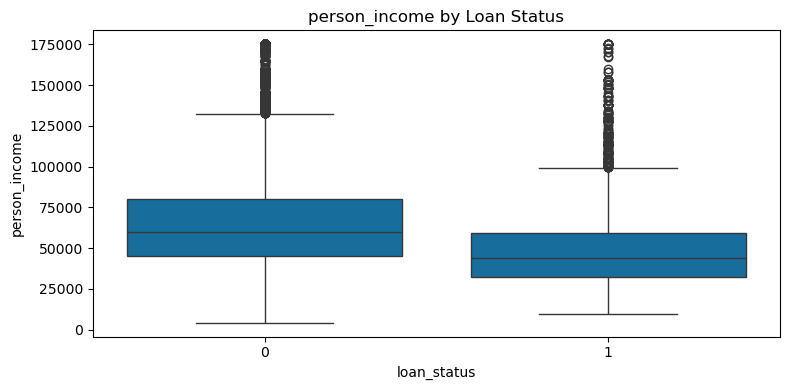

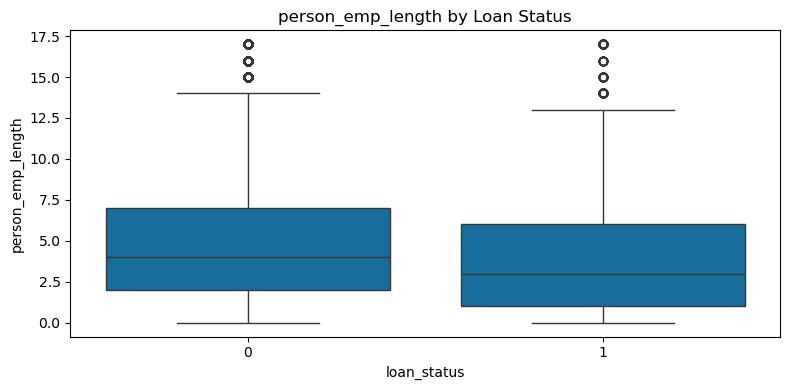

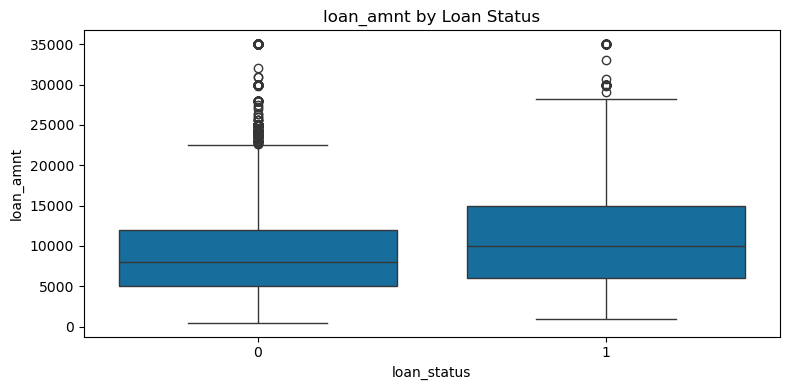

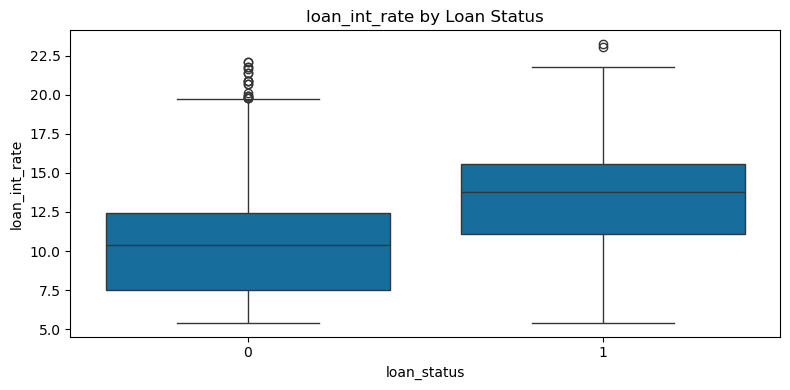

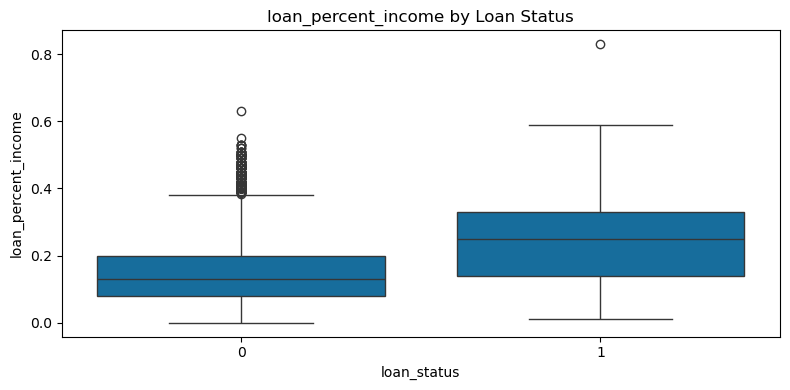

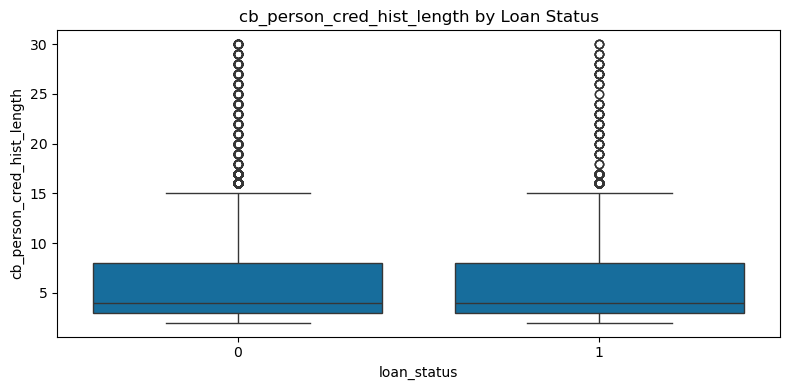

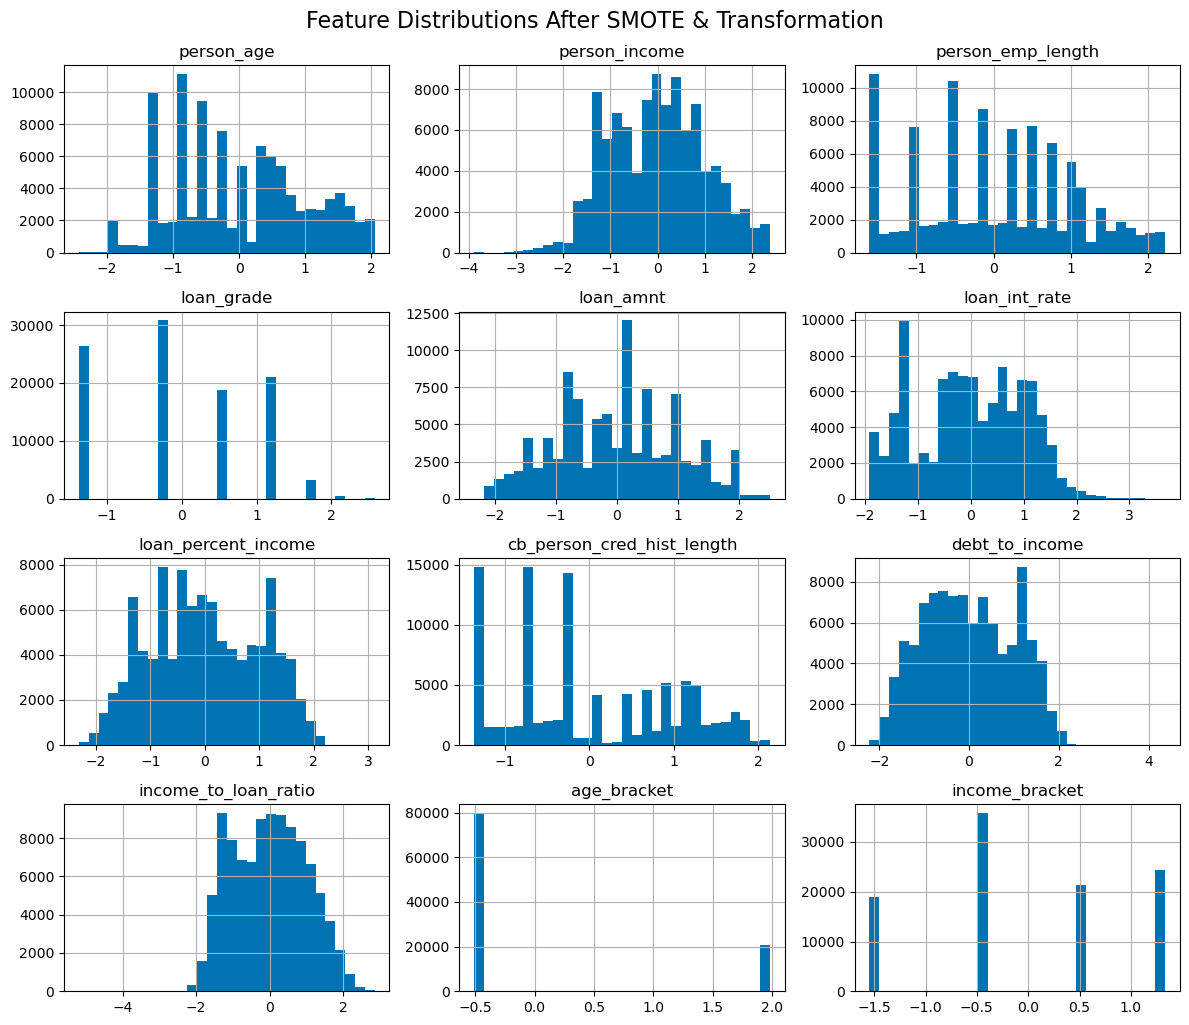


Skewness After SMOTE (Restricted to Original Numeric Features):

cb_person_cred_hist_length    0.276108
person_age                    0.204500
person_emp_length             0.095030
person_income                 0.081919
loan_percent_income           0.071972
loan_amnt                     0.067709
loan_int_rate                -0.050786
dtype: float64


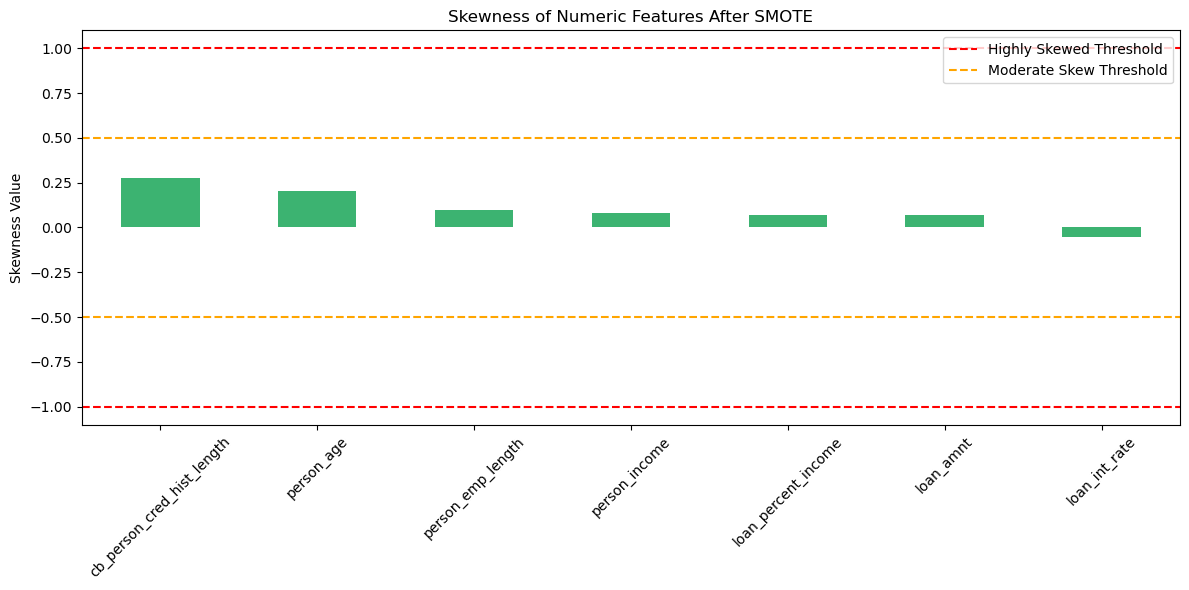

Validation Set Model Comparison:
                     Accuracy  Precision  Recall  F1 Score  AUC-ROC
Random Forest          0.9482     0.9561  0.9396    0.9478   0.9885
Logistic Regression    0.8154     0.8121  0.8208    0.8164   0.8941
Decision Tree          0.8709     0.9233  0.8089    0.8623   0.9338
XGBoost                0.9627     0.9782  0.9465    0.9621   0.9912
✅ ELI5 Feature Importance saved as HTML
✅ Optimal Threshold Found: 0.51 (F1 Score: 0.9624)

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     10059
           1       0.98      0.95      0.96     10059

    accuracy                           0.96     20118
   macro avg       0.96      0.96      0.96     20118
weighted avg       0.96      0.96      0.96     20118



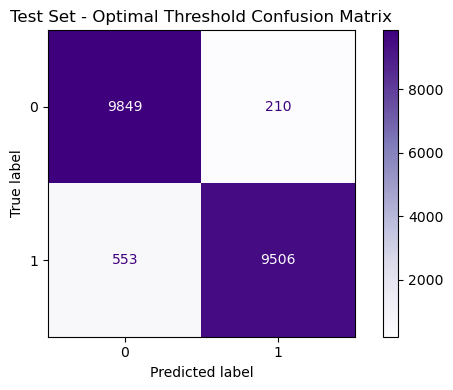

✅ Optimal threshold (0.5100) saved to optimal_threshold.txt
✅ Best model saved to loan_approval_model.pkl
✅ Best Model Selected: XGBoost
----- Performance Comparison Across Splits -----
           Training  Validation   Test
Accuracy     0.9754      0.9627 0.9621
Precision    0.9912      0.9782 0.9784
Recall       0.9593      0.9465 0.9450
F1 Score     0.9750      0.9621 0.9614
AUC-ROC      0.9965      0.9912 0.9909


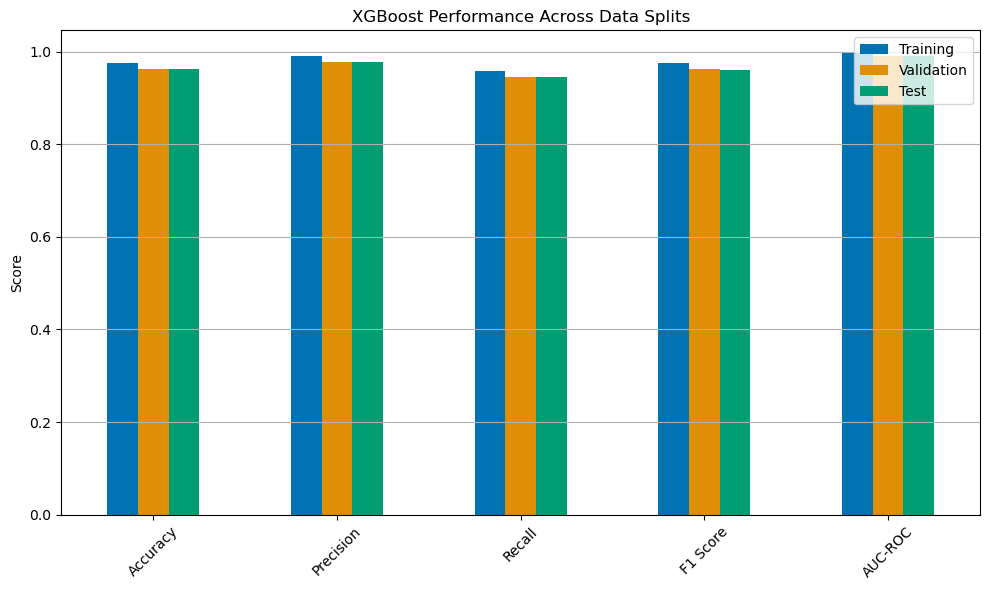

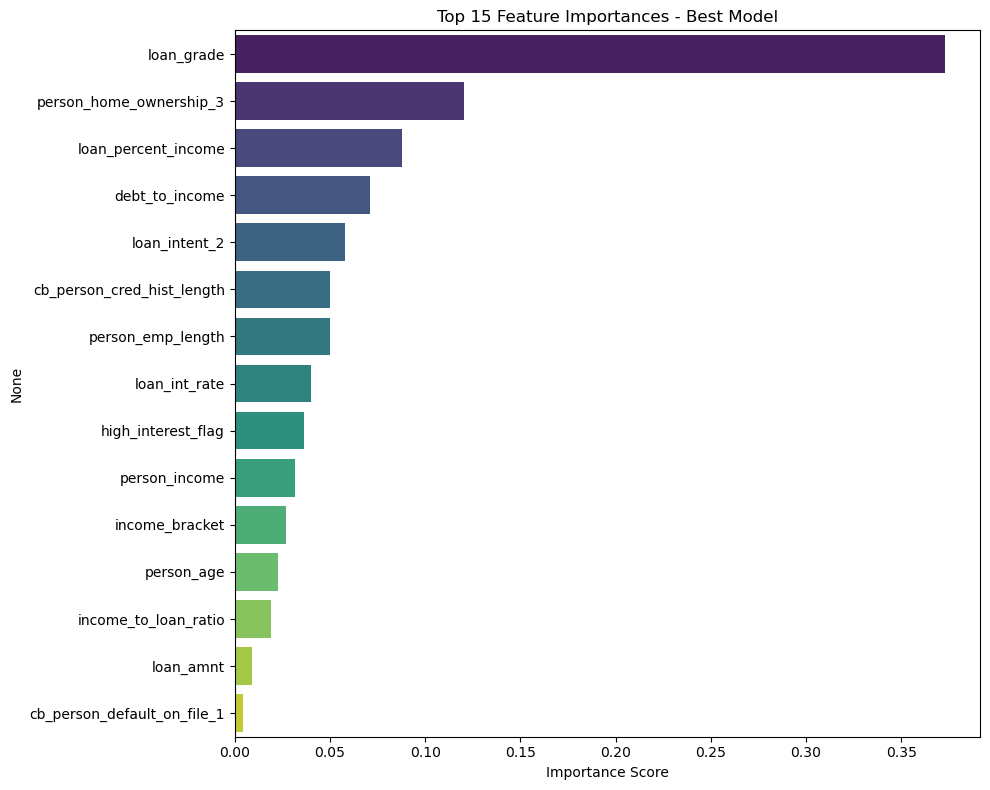

✅ Export Complete.


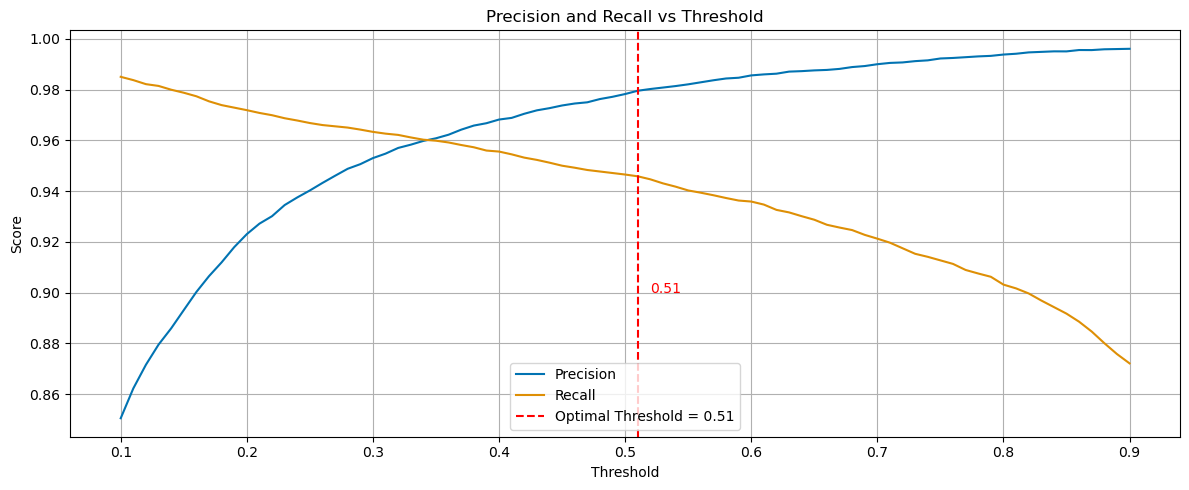

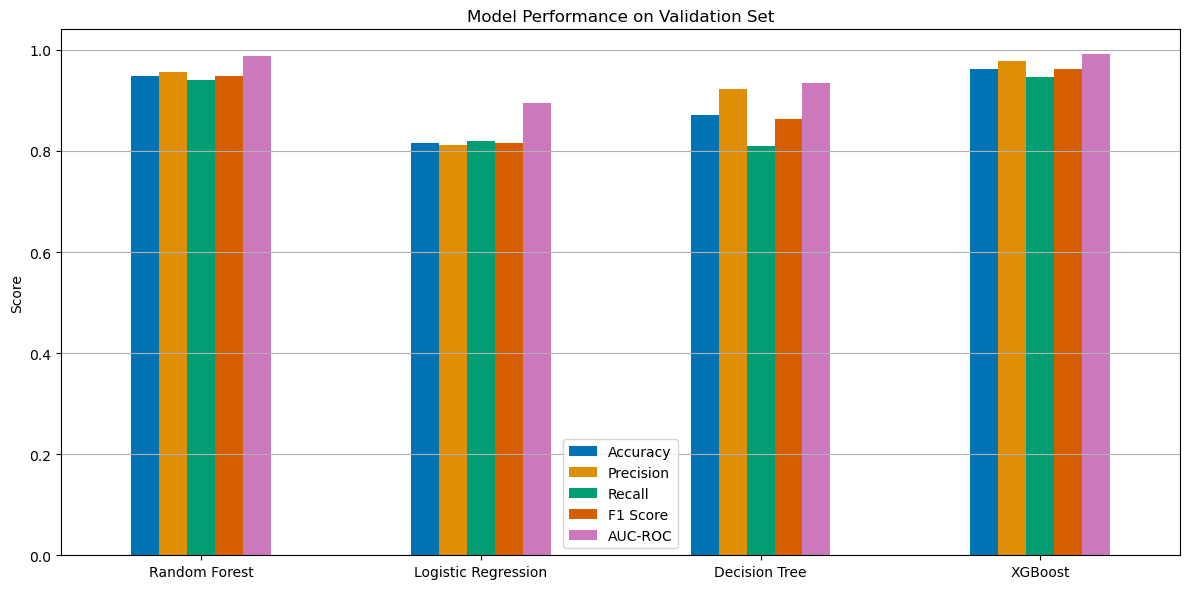

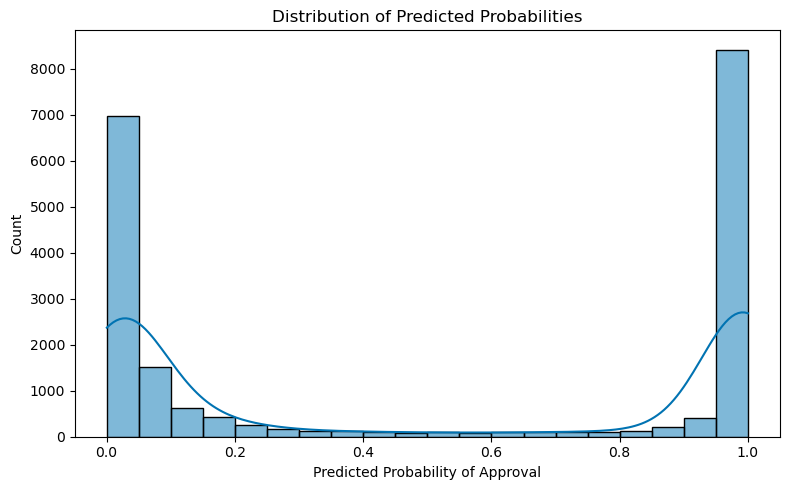

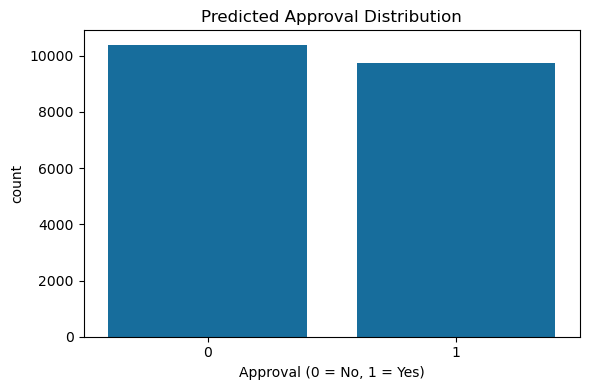

✅ Export Complete.
Loan Approval Prediction:
 • Approval Probability: 0.7902
 • Decision: APPROVED


In [ ]:
# Combined Loan Approval Prediction Script (Final Version)
# Includes elements from Final Project(M).py, Group_Projet-Caps.ipynb, and deployment module



# ===============================
# 0. LIBRARIES & ENVIRONMENT
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, classification_report
)
from imblearn.over_sampling import SMOTE

try:
    import eli5
    from eli5.sklearn import PermutationImportance
    eli5_available = True
except ImportError:
    eli5_available = False

os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())
sns.set_palette("colorblind")

# ===============================
# 1. LOAD DATA
# ===============================
train_df = pd.read_csv(r"C:\Users\prais\Desktop\Capstone Project\Loan_Approval_Prediction_train.csv")

# ===============================
# 2. CLEANING & IMPUTATION
# ===============================
numerical_features = [
    "person_age", "person_income", "person_emp_length", "loan_amnt",
    "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"
]
categorical_features = ["loan_grade", "loan_intent", "person_home_ownership", "cb_person_default_on_file"]

num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
train_df[numerical_features] = num_imputer.fit_transform(train_df[numerical_features])
train_df[categorical_features] = cat_imputer.fit_transform(train_df[categorical_features])

for col in ["person_age", "person_income", "person_emp_length"]:
    upper = train_df[col].quantile(0.99)
    train_df[col] = np.where(train_df[col] > upper, upper, train_df[col])

# ===============================
# 2B. HISTOGRAMS & BOXPLOTS
# ===============================
skewness = train_df.select_dtypes(include='number').skew().sort_values(ascending=False)

# Display skewness values
print("Skewness of Numeric Features:\n")
print(skewness)

# Plot skewness
plt.figure(figsize=(10, 6))
skewness.plot(kind='bar', color='skyblue')
plt.title("Skewness of Numeric Features")
plt.ylabel("Skewness Value")
plt.xticks(rotation=45)
plt.axhline(1, color='red', linestyle='--', label='Highly Skewed Threshold')
plt.axhline(0.5, color='orange', linestyle='--', label='Moderate Skew Threshold')
plt.axhline(-0.5, color='orange', linestyle='--')
plt.axhline(-1, color='red', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# Display histograms of numeric features
hist_columns = train_df.select_dtypes(include='number').columns.drop(['id'], errors='ignore')
train_df[hist_columns].hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.suptitle("Feature Distributions", fontsize=16, y=1.02)
plt.show()

# Boxplots for each numeric column vs loan_status
for col in train_df.select_dtypes(include='number').columns:
    if col not in ['id', 'loan_status']:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='loan_status', y=col, data=train_df)
        plt.title(f"{col} by Loan Status")
        plt.tight_layout()
        plt.show()

# ===============================
# 3. FEATURE ENGINEERING
# ===============================
train_df["debt_to_income"] = train_df["loan_amnt"] / (train_df["person_income"] + 1)
train_df["income_to_loan_ratio"] = train_df["person_income"] / (train_df["loan_amnt"] + 1)
train_df["high_interest_flag"] = (train_df["loan_int_rate"] > train_df["loan_int_rate"].median()).astype(int)
train_df["long_employment_flag"] = (train_df["person_emp_length"] > 10).astype(int)
train_df["long_credit_history"] = (train_df["cb_person_cred_hist_length"] > 5).astype(int)
train_df["age_bracket"] = pd.cut(train_df["person_age"], bins=[18, 30, 45, 60, 100], labels=["18-30", "31-45", "46-60", "60+"])
train_df["income_bracket"] = pd.qcut(train_df["person_income"], q=4, labels=["low", "mid-low", "mid-high", "high"])

# ===============================
# 4. ENCODING & SCALING
# ===============================
label_cols = ["age_bracket", "income_bracket"]
le = LabelEncoder()
for col in label_cols + categorical_features:
    train_df[col] = le.fit_transform(train_df[col])
train_df = pd.get_dummies(train_df, columns=["loan_intent", "person_home_ownership", "cb_person_default_on_file"], drop_first=True)
scaler = MinMaxScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])

# ===============================
# 5. SPLIT + SMOTE + TRANSFORM
# ===============================
X = train_df.drop(columns=["id", "loan_status"], errors='ignore')
y = train_df["loan_status"]
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
numeric_cols_to_transform = [col for col in X.columns if X[col].nunique() > 2 and pd.api.types.is_numeric_dtype(X[col])]
pt = PowerTransformer(method='yeo-johnson')
X[numeric_cols_to_transform] = pt.fit_transform(X[numeric_cols_to_transform])

# Display histograms of transformed features after SMOTE
X[numeric_cols_to_transform].hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.suptitle("Feature Distributions After SMOTE & Transformation", fontsize=16, y=1.02)
plt.show()

# === Display skewness after SMOTE ===
original_numeric_features = [
    "person_income", "person_emp_length", "loan_status", "person_age",
    "cb_person_cred_hist_length", "loan_amnt", "loan_percent_income", "loan_int_rate", "id"
]

# Filter columns that still exist after resampling
existing_features = [col for col in original_numeric_features if col in X.columns]
skew_after_smote = pd.DataFrame(X[existing_features]).skew().sort_values(ascending=False)

print("\nSkewness After SMOTE (Restricted to Original Numeric Features):\n")
print(skew_after_smote)

# Visualization (restricted set)
plt.figure(figsize=(12, 6))
skew_after_smote.plot(kind='bar', color='mediumseagreen')
plt.title("Skewness of Numeric Features After SMOTE")
plt.ylabel("Skewness Value")
plt.xticks(rotation=45)
plt.axhline(1, color='red', linestyle='--', label='Highly Skewed Threshold')
plt.axhline(0.5, color='orange', linestyle='--', label='Moderate Skew Threshold')
plt.axhline(-0.5, color='orange', linestyle='--')
plt.axhline(-1, color='red', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()
# ===============================
# 6. TRAIN/TEST SPLIT + FEATURE SELECTION
# ===============================
rf_temp = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_temp.fit(X, y)
top_features = pd.Series(rf_temp.feature_importances_, index=X.columns).nlargest(15).index.tolist()
X = X[top_features]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# ===============================
# 7. MODEL TRAINING
# ===============================
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
lr = LogisticRegression(max_iter=1000)
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), {"max_depth": [3, 5, 7]}, scoring="f1", cv=5)
xgb_grid = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), {"max_depth": [3, 5, 7], "n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, scoring="f1", cv=5)

rf.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)

dt = dt_grid.best_estimator_
xgb = xgb_grid.best_estimator_

models = {
    "Random Forest": rf,
    "Logistic Regression": lr,
    "Decision Tree": dt,
    "XGBoost": xgb
}

# ===============================
# 8. VALIDATION EVALUATION
# ===============================
results_val = {}
for name, model in models.items():
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    results_val[name] = {
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred),
        "Recall": recall_score(y_val, y_val_pred),
        "F1 Score": f1_score(y_val, y_val_pred),
        "AUC-ROC": roc_auc_score(y_val, y_val_proba)
    }
results_df_val = pd.DataFrame(results_val).T
print("Validation Set Model Comparison:")
print(results_df_val.round(4))

# ===============================
# 9. ELI5 FEATURE IMPORTANCE
# ===============================
best_model_name = results_df_val['AUC-ROC'].idxmax()
best_model = models[best_model_name]
try:
    perm = PermutationImportance(best_model, random_state=42).fit(X_val, y_val)
    html = eli5.show_weights(perm, feature_names=X.columns.tolist())
    with open("eli5_feature_importance.html", "w") as f:
        f.write(html.data)
    print("✅ ELI5 Feature Importance saved as HTML")
except Exception as e:
    print("❌ ELI5 failed:", e)

# ===============================
# 10. THRESHOLD OPTIMIZATION
# ===============================
if hasattr(best_model, "predict_proba"):
    predicted_probs = best_model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 81)
    scores = []
    for t in thresholds:
        y_pred = (predicted_probs >= t).astype(int)
        scores.append({
            "Threshold": t,
            "Accuracy": accuracy_score(y_val, y_pred),
            "Precision": precision_score(y_val, y_pred),
            "Recall": recall_score(y_val, y_pred),
            "F1 Score": f1_score(y_val, y_pred)
        })
    scores_df = pd.DataFrame(scores)
    best_row = scores_df.loc[scores_df['F1 Score'].idxmax()]
    optimal_threshold = best_row['Threshold']
    print(f"✅ Optimal Threshold Found: {optimal_threshold:.2f} (F1 Score: {best_row['F1 Score']:.4f})")
    y_test_pred = (best_model.predict_proba(X_test)[:, 1] >= optimal_threshold).astype(int)
    print("\nClassification Report at Optimal Threshold:")
    print(classification_report(y_test, y_test_pred))

# Optimal Threshold Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax, cmap="Purples")
ax.set_title("Test Set - Optimal Threshold Confusion Matrix")
plt.tight_layout()
plt.show()

y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)


# ===============================
# 10B. SAVE BEST MODEL & THRESHOLD
# ===============================

# Persist the optimal threshold
with open('optimal_threshold.txt', 'w') as f:
    f.write(f"{optimal_threshold:.6f}")
print(f"✅ Optimal threshold ({optimal_threshold:.4f}) saved to optimal_threshold.txt")

# Persist the best model
with open('loan_approval_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✅ Best model saved to loan_approval_model.pkl")


# Plot: Final Model Performance Across Splits
results_all_df = pd.DataFrame({
    "Training": {
        "Accuracy": accuracy_score(y_train, best_model.predict(X_train)),
        "Precision": precision_score(y_train, best_model.predict(X_train)),
        "Recall": recall_score(y_train, best_model.predict(X_train)),
        "F1 Score": f1_score(y_train, best_model.predict(X_train)),
        "AUC-ROC": roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
    },
    "Validation": results_val[best_model_name],
    "Test": {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1 Score": f1_score(y_test, y_test_pred),
        "AUC-ROC": roc_auc_score(y_test, y_test_proba)
    }
})

best_model_name = results_df_val['AUC-ROC'].idxmax()
best_model = models[best_model_name]
print(f"✅ Best Model Selected: {best_model_name}")

print("----- Performance Comparison Across Splits -----")
print(results_all_df.to_string(float_format="%.4f"))

results_all_df.plot(kind='bar', figsize=(10, 6))
plt.title(f"{best_model_name} Performance Across Data Splits")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# FEATURE IMPORTANCE (Bar Plot)
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    top_importances = importances.sort_values(ascending=False).head(15)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_importances.values, y=top_importances.index, hue=top_importances.index, palette="viridis", legend=False)
    plt.title("Top 15 Feature Importances - Best Model")
    plt.xlabel("Importance Score")
    plt.subplots_adjust(top=0.92, bottom=0.15)
plt.tight_layout()
plt.show()
  
# PRECISION & RECALL vs THRESHOLD
thresholds = np.linspace(0.1, 0.9, 81)
precisions = []
recalls = []

for t in thresholds:
    y_thresh_pred = (best_model.predict_proba(X_val)[:, 1] >= t).astype(int)
    precisions.append(precision_score(y_val, y_thresh_pred))
    recalls.append(recall_score(y_val, y_thresh_pred))

plt.figure(figsize=(12, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.title('Precision and Recall vs Threshold')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.text(optimal_threshold + 0.01, 0.9, f'{optimal_threshold:.2f}', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show
    
# ===============================
# 11. FAIRNESS ANALYSIS
# ===============================
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_prefix = f"loan_model_output_{timestamp}"
train_df['income_bracket'] = pd.qcut(train_df['person_income'], q=4, labels=["low", "mid-low", "mid-high", "high"])
sensitive_features = ['loan_grade', 'income_bracket']
fairness_summary = {}
for feature in sensitive_features:
    stats = train_df.groupby(feature, observed=False)['loan_status'].agg(['mean', 'count']).reset_index()
    stats.columns = [feature, 'Approval Rate', 'Applicants']
    stats['Feature'] = feature
    fairness_summary[feature] = stats

fairness_df = pd.concat(fairness_summary.values(), axis=0)
fairness_df.to_csv(f"{output_prefix}_fairness.csv", index=False)
print("✅ Export Complete.")

# ===============================
# 12. MODEL PERFORMANCE VISUALS
# ===============================
results_df_val.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance on Validation Set")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

if hasattr(best_model, "predict_proba"):
    plt.figure(figsize=(8, 5))
    sns.histplot(best_model.predict_proba(X_val)[:, 1], bins=20, kde=True)
    plt.title("Distribution of Predicted Probabilities")
    plt.xlabel("Predicted Probability of Approval")
    plt.tight_layout()
    plt.show()

    predicted_classes = (predicted_probs >= 0.5).astype(int)
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predicted_classes)
    plt.title("Predicted Approval Distribution")
    plt.xlabel("Approval (0 = No, 1 = Yes)")
    plt.tight_layout()
    plt.show()

# ===============================
# 13. EXPORT RESULTS
# ===============================
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_prefix = f"loan_model_output_{timestamp}"
results_df_val.to_csv(f"{output_prefix}_val_metrics.csv", index=True)

# Save fairness summaries
fairness_summary = {}
for feature in sensitive_features:
    stats = train_df.groupby(feature, observed=False)['loan_status'].agg(['mean', 'count']).reset_index()
    stats.columns = [feature, 'Approval Rate', 'Applicants']
    stats['Feature'] = feature
    fairness_summary[feature] = stats

fairness_df = pd.concat(fairness_summary.values(), axis=0)
fairness_df.to_csv(f"{output_prefix}_fairness.csv", index=False)
print("✅ Export Complete.")




In [20]:
# ===============================
# DEPLOYMENT PREDICTION FUNCTION & RELATED UTILITIES
# ===============================
import pickle
import pandas as pd

# 1) List of the exact 15 features your model was trained on, in the same order:
required_features = [
    'loan_int_rate',
    'debt_to_income',
    'loan_grade',
    'loan_percent_income',
    'income_to_loan_ratio',
    'person_income',
    'person_home_ownership_3',
    'person_emp_length',
    'cb_person_cred_hist_length',
    'loan_amnt',
    'person_age',
    'high_interest_flag',
    'loan_intent_2',
    'cb_person_default_on_file_1',
    'income_bracket'
]

def load_model_and_threshold(model_path='loan_approval_model.pkl',
                             threshold_path='optimal_threshold.txt'):
    """
    Loads the pickled model and the optimal decision threshold.
    """
    with open(model_path, 'rb') as mf:
        model = pickle.load(mf)
    with open(threshold_path, 'r') as tf:
        threshold = float(tf.read().strip())
    return model, threshold

def validate_input(input_data):
    """
    Ensures the input_data dict has exactly the required_features keys.
    """
    missing = [f for f in required_features if f not in input_data]
    if missing:
        raise ValueError(f"Missing features for prediction: {missing}")
    extra = [k for k in input_data if k not in required_features]
    if extra:
        raise ValueError(f"Unexpected features provided: {extra}")
    return True

def predict_loan_approval(input_data):
    """
    input_data: dict containing the 15 model-ready features.
    Returns: dict with 'probability' of approval and boolean 'decision'.
    """
    # 1) Validate feature set
    validate_input(input_data)

    # 2) Load model and threshold
    model, threshold = load_model_and_threshold()

    # 3) Build DataFrame in the correct column order
    X = pd.DataFrame([input_data], columns=required_features)

    # 4) Predict probability and decision
    proba = model.predict_proba(X)[0, 1]
    #decision = proba >= threshold
    decision = proba >= 0.9

    return {
        'probability': proba,
        'decision': bool(decision)
    }

# ===============================
# EXAMPLE APPLICATION TEST CASE
# ===============================
if __name__ == '__main__':
    # Compute these 15 features manually (ensure codes match your training encodings)
    test_application = {
        'loan_int_rate':             0.5,
        'debt_to_income':            10000 / (50000),
        'loan_grade':                3,   # e.g. A→0, B→1, C→2, D→3, …
        'loan_percent_income':       0.17,
        'income_to_loan_ratio':      50000 / (100000),
        'person_income':             1000,
        'person_home_ownership_3':   1,   # e.g. code for RENT/OWN/OTHER
        'person_emp_length':         18,
        'cb_person_cred_hist_length': 1,
        'loan_amnt':                 100000,
        'person_age':                20,
        'high_interest_flag':        int(10.5 > 13.5),  # replace 13.5 with your training median
        'loan_intent_2':             1,   
        'cb_person_default_on_file_1': 0,
        'income_bracket':            2    
    }

    result = predict_loan_approval(test_application)
    print("Loan Approval Prediction:")
    print(f" • Approval Probability: {result['probability']:.4f}")
    print(f" • Decision: {'APPROVED' if result['decision'] else 'REJECTED'}")


Loan Approval Prediction:
 • Approval Probability: 0.7542
 • Decision: REJECTED
